<a href="https://colab.research.google.com/github/data-better/ASL/blob/master/transformer_keras_tutorial_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

tf.enable_eager_execution()

W0810 23:19:16.855297 140151678171008 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Dataload

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info = True, as_supervised = True)
train_examples, val_examples = examples['train'], examples['validation']

W0810 23:19:46.525863 140151678171008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/0.0.1. Subsequent calls will reuse this data.


W0810 23:19:48.578250 140151678171008 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [ ]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size = 2 ** 13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size = 2 ** 13)

In [ ]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [ ]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
## Add start, end sign
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]
  return lang1, lang2

In [ ]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length = MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [ ]:
def tf_encode(pt, en):
  return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes = ([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

In [ ]:
train_dataset

<DatasetV1Adapter shapes: ((?, ?), (?, ?)), types: (tf.int64, tf.int64)>

### Check data

In [ ]:
# 10개 sample을 가져와서
te = train_examples.take(10)
# encoding
tem = te.map(tf_encode)

In [ ]:
# 그중 1개의 원문, encoding, decoding, token을 출력
for i, (a, b) in enumerate(zip(te, tem)):
  if i == 1:
    break
  pt_txt, en_txt= a
  pt_enc, en_enc = b
  en_dec = tokenizer_en.decode(en_enc[1:-1])
  print(' en_text = {}, \n en_encoding = {}, \n en_decoding = {}'.format(en_txt, en_enc, en_dec))
  for ts in en_enc[1:-1]:
    print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))
  

 en_text = b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them .", 
 en_encoding = [8087 6864    9   83  300   10  146 3082   11    3 4655 7863   86    7
  808    1    4   25 3823 5814 7863   10   87    5   47 4661 7863    6
  100   24   45  820 7876   53 1275   10  203   34  180    5 5999 7863
  199    1   23   14   24 7941 7870   26  436  185    6  161    2 8088], 
 en_decoding = astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them .
6864 ----> astronomer
9 ----> s 
83 ----> now 
300 ----> believe 
10 ----> that 
146 ----> every 
3082 ----> star 
11 ----> in 
3 ----> the 
4655 ----> galaxy
7863 ---->  
86 ----> has 
7 ----> a 
808 ----> planet
1 ---->  , 
4 ----> and 


In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=326960, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=326961, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

In [ ]:
en_batch

<tf.Tensor: id=326961, shape=(64, 40), dtype=int64, numpy=
array([[8087,   18,   12, ...,    0,    0,    0],
       [8087,  634,   30, ...,    0,    0,    0],
       [8087,   16,   13, ...,    0,    0,    0],
       ...,
       [8087,   12,   20, ...,    0,    0,    0],
       [8087,   17, 4981, ...,    0,    0,    0],
       [8087,   12, 5453, ...,    0,    0,    0]])>

## Positional encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * ( i//2) /np.float32(d_model)))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model) # np.newaxis => Add axis
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype = tf.float32)  

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

(1, 50, 512)


### 설명

In [ ]:
# angle을 계산. 2개의 같은 각도 pair가 총 512개, 256개의 distinct한 angle 값을 지님 
angle_rads = get_angles(np.arange(50)[:, np.newaxis], np.arange(512)[np.newaxis, :], 512)
print(angle_rads[:, 0::2][1][:3])
print(angle_rads[:, 1::2][1][:3])

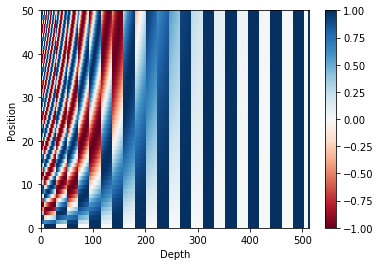

In [ ]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [ ]:
# 패딩을 참조하지 않도록...
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=326979, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
# 나타나지 않은 포지션을 참조하지 않도록
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=326995, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled Dot Product Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b = True) #(..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  
  # add the mask to the scaled tensor
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)
    
  # softmax on the last axis
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
  output = tf.matmul(attention_weights, v)
  return output, attention_weights
  

## Multi-head attention